article class = sc-1ww42at-0, EyLft qjwil1-0 iCnXma

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [4]:
# send requests
result_list = []
max = 30

for i in range(max):
    url = 'https://www.immoscout24.ch/de/wohnung/mieten/ort-luzern?pn={}&r=6'.format(i+1)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw_data = soup.find(id='state')
    jason_data = json.loads(raw_data.string[25:])
    data_list = jason_data['pages']['searchResult']['resultData']['listData']

    page_list = []

    for elem in data_list:
        if 'price' in elem: price = elem['price']
        else: price = np.nan

        if 'surfaceLiving' in elem: sl = elem['surfaceLiving']
        else: sl = np.nan

        if 'numberOfRooms' in elem: nor = elem['numberOfRooms']
        else: nor = np.nan

        if 'title' in elem: ttl = elem['title']
        else: ttl = np.nan

        if 'latitude' in elem: lat = elem['latitude']
        else: lat = np.nan

        if 'longitude' in elem: lon = elem['longitude']
        else: lon = np.nan

        page_list.append([elem['id'], price, nor, sl, ttl, elem['zip'], lat, lon])

    result_list += page_list

#result_list

In [6]:
result_df = pd.DataFrame(result_list)
result_df.columns = ['Id', 'Price', 'RoomNr', 'Surface', 'Title', 'ZIP', 'Latitude', 'Longitude']

#result_df.dropna(inplace=True)
result_df

,Id,Price,RoomNr,Surface,Title,ZIP,Latitude,Longitude
0,5964984,1700.0,2.5,68.0,Ihr neues Zuhause?,6010,47.02889,8.29199
1,5967052,1570.0,2.5,62.0,Erfüllen Sie sich Ihren Wohntraum!,6020,47.08200,8.27239
2,5967051,2080.0,3.5,75.0,Mitten in der Stadt und mit einem Hauch von Lu...,6003,47.04333,8.30465
3,5879782,1450.0,3.5,77.0,Hoch hinaus - Wohnen im Listrighochhaus!,6020,47.08092,8.26496
4,4571524,1280.0,2.0,51.0,Zentral und an bester Wohnlage?,6020,47.08093,8.26953
...,...,...,...,...,...,...,...,...
703,5950166,2100.0,3.5,96.0,Nachmieter gesucht per 30.05.2020,6030,47.08026,8.34205
704,5955667,2148.0,4.5,100.0,Lichtdurchflutete 4.5- Zimmerwohnung in Meggen,6045,47.04949,8.36791
705,5708520,2200.0,3.5,97.0,Neue 3.5 Zimmer Maisonette-Wohnung in Chalet m...,6020,47.07516,8.27169
706,5875601,2300.0,4.5,120.0,Gehobenes Wohnen auf 120m2!,6020,47.07215,8.28931


In [7]:
# create map of lucerne using latitude and longitude values
map_lucerne = folium.Map(location=[47.05, 8.3], zoom_start=12.5)

linear = cm.LinearColormap(
    ['green', 'red'],
    vmin=100, vmax=8000
)

linear

# add markers to map
for lat, lng, price in zip(result_df['Latitude'], result_df['Longitude'], result_df['Price']):
    label = folium.Popup(str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=linear(price),
        fill=True,
        fill_color=linear(price),
        fill_opacity=0.7,
        parse_html=False).add_to(map_lucerne)

map_lucerne  

In [47]:
CLIENT_ID = 'VV5H111QRCSXOLD5LF52CDDBI1S1QPDX5BFBOI3IJQHGYI4L' # your Foursquare ID
CLIENT_SECRET = 'TEH4SQMZBUB1VHCJZQYNLNHCQTBLTEXIHBLY1VWM1FMSYU1N' # your Foursquare Secret
VERSION = '20180604'
RADIUS = 250
LIMIT = 50

Your credentails:
CLIENT_ID: VV5H111QRCSXOLD5LF52CDDBI1S1QPDX5BFBOI3IJQHGYI4L
CLIENT_SECRET:TEH4SQMZBUB1VHCJZQYNLNHCQTBLTEXIHBLY1VWM1FMSYU1N


In [27]:
sample = result_df.head(300)
#sample.to_csv('300_flats')

In [48]:

venues_list=[]

for flatID, flatLat, flatLon in zip(sample['Id'], sample['Latitude'], sample['Longitude']):

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, flatLat, flatLon, VERSION, RADIUS, LIMIT)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    for v in results:
        venues_list.append([
            flatID,
            v['venue']['categories'][0]['name']
        ])

venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['ID', 'Category']

onehot = pd.get_dummies(venues_df['Category'],  prefix="", prefix_sep="")
onehot['ID'] = venues_df['ID']
onehot = onehot.groupby('ID').sum()

In [49]:
onehot['sum'] = onehot.sum(axis=1)
onehot

,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Store,Bowling Alley,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Station,Bus Stop,Cable Car,Café,Campground,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cultural Center,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Light Rail Station,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Music Venue,Nightclub,Noodle House,Other Great Outdoors,Outdoors & Recreation,Paella Restaurant,Paintball Field,Park,Pedestrian Plaza,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pub,Racetrack,Rental Car Location,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Sculpture Garden,Shop & Service,Shopping Mall,Soccer Field,Soccer Stadium,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Train Station,Trattoria/Osteria,Tunnel,Water Park,Wine Shop,sum
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
602096,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3414889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
3529953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,15
3862159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
3875847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977396,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0

In [20]:
#onehot.to_csv('300_onehot.csv')
onehot = pd.read_csv('300_onehot.csv')

In [24]:
pois = [
    'Bus Station',
    'Bus Stop',
    'Convenience Store',
    'Discount Store',
    'Grocery Store',
    'Light Rail Station',
    #'Market',
    'Shopping Mall',
    'Supermarket',
    'Train Station'
]

#onehot.set_index('ID', inplace=True)
onehot = onehot[pois]
onehot['sum'] = onehot.sum(axis=1)
onehot

,Bus Station,Bus Stop,Convenience Store,Discount Store,Grocery Store,Light Rail Station,Shopping Mall,Supermarket,Train Station,sum
ID,,,,,,,,,,
602096,0,0,0,0,0,0,0,0,0,0
2745834,0,0,0,0,0,0,0,0,0,0
3414889,1,0,0,0,0,0,0,1,0,2
3529953,0,1,1,0,1,0,1,1,0,5
3862159,0,2,0,0,4,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...
5977406,1,0,0,1,1,0,1,0,0,4
5977425,0,0,0,0,0,0,0,1,0,1
5977466,0,1,0,0,1,0,1,0,0,3


In [25]:
#data = pd.read_csv('300_onehot.csv')
#data.set_index('ID', inplace=True)
data = onehot

In [28]:
gsample = sample.groupby('Id').sum()
gsample

,Price,RoomNr,Surface,Latitude,Longitude
Id,,,,,
602096,1670.0,4.5,85.0,47.04672,8.28971
2745834,1495.0,3.5,78.0,47.04594,8.29111
3414889,1500.0,4.0,85.0,47.03438,8.28420
3529953,1563.0,2.5,45.0,47.05900,8.30956
3862159,1510.0,4.0,75.0,47.03883,8.31386
...,...,...,...,...,...
5977425,1430.0,2.5,67.0,47.03292,8.28878
5977466,1820.0,5.5,110.0,47.08724,8.35206
5977542,1725.0,3.5,90.0,47.08026,8.34205


,Price,RoomNr,Surface,Latitude,Longitude,sum
Price,1.000000,NaN,0.565537,-0.177842,0.176433,0.089032
RoomNr,NaN,NaN,NaN,NaN,NaN,NaN
Surface,0.565537,NaN,1.000000,0.128113,0.119949,-0.074373
Latitude,-0.177842,NaN,0.128113,1.000000,0.056268,0.118029
Longitude,0.176433,NaN,0.119949,0.056268,1.000000,0.081305
sum,0.089032,NaN,-0.074373,0.118029,0.081305,1.000000


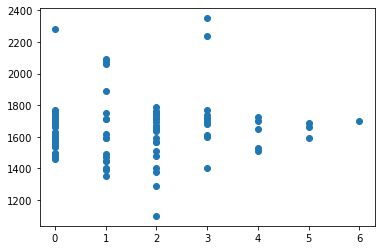

In [30]:
joined_df = gsample.join(data['sum'], how='right')

#filter = (joined_df['Surface'] <= 90) & (joined_df['Surface'] >= 80)
filter = joined_df['RoomNr'] == 3.5
filtered_df = joined_df[filter]

plt.scatter(filtered_df['sum'], filtered_df['Price'])
filtered_df.corr()

In [38]:
# create another map of lucerne using latitude and longitude values
map_lucerne2 = folium.Map(location=[47.05, 8.3], zoom_start=12.5)

linear = cm.LinearColormap(
    ['green', 'red'],
    vmin=1100, vmax=2350
)

linear

# add markers to map
for lat, lng, price in zip(filtered_df['Latitude'], filtered_df['Longitude'], filtered_df['Price']):
    label = folium.Popup(str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=linear(price),
        fill=True,
        fill_color=linear(price),
        fill_opacity=0.7,
        parse_html=False).add_to(map_lucerne2)

map_lucerne2